In [1]:
## Import the dependencies
import os
import shutil
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,Dropout

In [2]:
## Check whether GPU is available or not
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Download the zipfile in jupyter Notebook
!python -m wget "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"


Saved under kagglecatsanddogs_5340.zip


In [4]:
## Unzip the files
local_zip = 'kagglecatsanddogs_5340.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [5]:
# Delete all files except the images from the folder
source_path = 'PetImages'
source_path_dogs = os.path.join(source_path, 'Dog/')
source_path_cats = os.path.join(source_path, 'Cat/')


for directory in (os.listdir(source_path)):
    for filename in (os.listdir(os.path.join(source_path, directory))):
        if filename.endswith(".jpg"):
            continue  # Skip JPG files
        filepath = os.path.join(source_path, directory, filename)
        os.remove(filepath)
    
# Check how many images are there in the folders
print(f"There are {len(os.listdir(source_path_cats))} images of cats") 
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs")

There are 12500 images of cats
There are 12500 images of dogs


In [6]:
## Create directories for training and validation images

root_dir = 'cats-v-dogs'

if os.path.exists(root_dir):
    shutil.rmtree(root_dir)
    
def create_train_val_dir(root_path):
    
    os.makedirs(root_path)
    train_dir = os.path.join(root_path, 'training/')
    val_dir = os.path.join(root_path, 'validation/')
    
    
    train_cats_dir = os.path.join(train_dir, 'cats/')
    train_dogs_dir = os.path.join(train_dir, 'dogs/')
    val_cats_dir = os.path.join(val_dir, 'cats/')
    val_dogs_dir = os.path.join(val_dir, 'dogs/')
    
    os.makedirs(train_cats_dir)
    os.makedirs(train_dogs_dir)
    os.makedirs(val_cats_dir)
    os.makedirs(val_dogs_dir)
    
    return train_dir, val_dir, train_cats_dir, train_dogs_dir, val_cats_dir, val_dogs_dir

In [7]:
train_dir, val_dir, train_cats_dir, train_dogs_dir, val_cats_dir, val_dogs_dir = create_train_val_dir(root_dir)

In [8]:
# Check the directories
for root_dir, dirs, files in os.walk(root_dir):
    for sub_dirs in dirs:
        print(os.path.join(root_dir, sub_dirs))

cats-v-dogs\training
cats-v-dogs\validation
cats-v-dogs\training\cats
cats-v-dogs\training\dogs
cats-v-dogs\validation\cats
cats-v-dogs\validation\dogs


In [9]:
#Split the data for training and validation
def split_data(source_dir, 
              training_dir,
              validation_dir, 
              split_size = 0.9):
    file_list = []
    
    for file in os.listdir(source_dir):
        file_path = os.path.join(source_dir, file)
        if (os.path.getsize(file_path)==0):
            print(file + " is zero length, so ignoring. ")
        else:
            file_list.append(file_path)
            
    train_num_items = int(round(len(file_list) * split_size, 0))
    train_list = random.sample(file_list, train_num_items)
    val_list = list(set(file_list) - set(train_list))
    
    for f in train_list:
        copyfile(f, training_dir+os.path.basename(f))
    for f in val_list:
        copyfile(f, validation_dir+os.path.basename(f))

In [10]:
CAT_SOURCE_DIR = 'PetImages/Cat/'
DOG_SOURCE_DIR = 'PetImages/Dog/'
## Run the following codes if are running the cell below multiple times
if len(os.listdir(train_cats_dir))>0:
    for file in os.scandir(train_cats_dir):
        os.remove(file.path)
if len(os.listdir(train_dogs_dir))>0:
    for file in os.scandir(train_dogs_dir):
        os.remove(file.path)
if len(os.listdir(val_cats_dir))>0:
    for file in os.scandir(val_cats_dir):
        os.remove(file.path)
if len(os.listdir(val_dogs_dir))>0:
    for file in os.scandir(val_dogs_dir):
        os.remove(file.path)

In [11]:
split_size = 0.9
split_data(CAT_SOURCE_DIR, train_cats_dir, val_cats_dir, split_size)
split_data(DOG_SOURCE_DIR, train_dogs_dir, val_dogs_dir, split_size)

666.jpg is zero length, so ignoring. 
11702.jpg is zero length, so ignoring. 


In [12]:
# Check how many valid images are there
print(f"There are {len(os.listdir(train_cats_dir))} images of cats for training")
print(f"There are {len(os.listdir(train_dogs_dir))} images of dogs for training")
print(f"There are {len(os.listdir(val_cats_dir))} images of cats for validation")
print(f"There are {len(os.listdir(val_dogs_dir))} images of dogs for validation")

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


In [13]:
# Create training and validation datagenerator
def train_val_generator(TRAIN_DIR, VAL_DIR):
    train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
    
    train_generator = train_datagen.flow_from_directory(directory = TRAIN_DIR,
                                                       batch_size = 50,
                                                       class_mode = 'binary',
                                                       target_size = (150,150))
    
    val_datagen = ImageDataGenerator(rescale = 1.0/255.)
    
    val_generator = val_datagen.flow_from_directory(directory = VAL_DIR,
                                                   batch_size = 50,
                                                   class_mode = 'binary',
                                                   target_size = (150, 150))
    return train_generator, val_generator

In [14]:
train_generator, validation_generator = train_val_generator(train_dir, val_dir)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [15]:
## Create the functional model
def create_model(learning_rate = 0.001):
    inputs = Input(shape = (150,150,3))
    x = Conv2D(16 ,3 ,activation = 'relu')(inputs)
    
    x = MaxPooling2D(2,2)(x)
    
    x = Conv2D(32 ,3 ,activation = 'relu')(x)
    
    x = MaxPooling2D(2,2)(x)
    
    x = Conv2D(64, 3, activation = 'relu')(x)
    
    x = MaxPooling2D(2,2)(x)
    
    x = Dropout(0.2)(x)
        
    x = Conv2D(128, 3, activation = 'relu')(x)
    
    x = MaxPooling2D(2,2)(x)
    
    x = Conv2D(256, 3, activation = 'relu')(x)
    
    x = MaxPooling2D(2,2)(x)
    
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    
    x = Dense(512, activation = 'relu')(x)
    
    outputs = Dense(1, activation = 'sigmoid')(x)
    
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    
    model.compile(optimizer = RMSprop(learning_rate = learning_rate),
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])
    return model

In [16]:
# Initialize the model and print the model summary
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

In [17]:
# Train the model
history = model.fit(train_generator,
                   epochs = 15,
                   validation_data = validation_generator,
                   verbose = 1)

Epoch 1/15
371/450 [=======================>......] - ETA: 1:17 - loss: 0.6899 - accuracy: 0.5575

D:\Users\Asus\anaconda3\envs\obj_detect\lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


450/450 [==============================] - 468s 1s/step - loss: 0.6864 - accuracy: 0.5655 - val_loss: 0.6685 - val_accuracy: 0.6376
Epoch 2/15
450/450 [==============================] - 180s 400ms/step - loss: 0.6493 - accuracy: 0.6288 - val_loss: 0.5984 - val_accuracy: 0.6852
Epoch 3/15
450/450 [==============================] - 239s 530ms/step - loss: 0.6041 - accuracy: 0.6788 - val_loss: 0.5686 - val_accuracy: 0.7024
Epoch 4/15
450/450 [==============================] - 556s 1s/step - loss: 0.5773 - accuracy: 0.7017 - val_loss: 0.4842 - val_accuracy: 0.7656
Epoch 5/15
450/450 [==============================] - 292s 648ms/step - loss: 0.5499 - accuracy: 0.7241 - val_loss: 0.4691 - val_accuracy: 0.7872
Epoch 6/15
450/450 [==============================] - 174s 386ms/step - loss: 0.5278 - accuracy: 0.7414 - val_loss: 0.4304 - val_accuracy: 0.8080
Epoch 7/15
450/450 [==============================] - 181s 402ms/step - loss: 0.5038 - accuracy: 0.7584 - val_loss: 0.4498 - val_accuracy: 0.

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [19]:
epochs=range(len(acc))

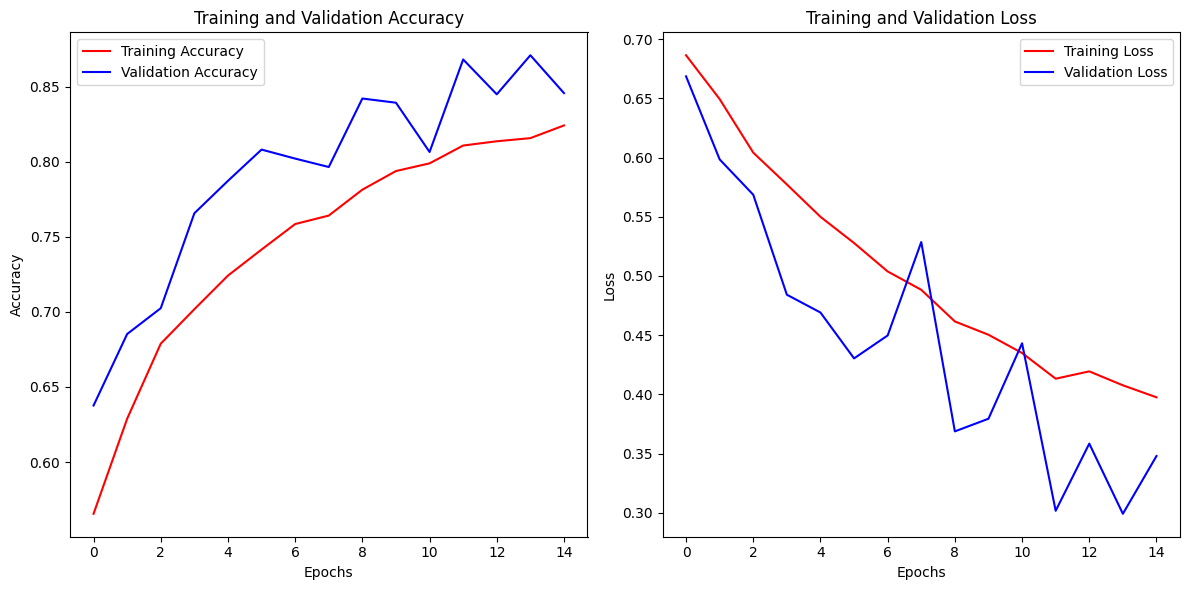

In [20]:
# Plotting Training and Validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

FileUpload(value=(), description='Upload', multiple=True)

1/1 [==============================] - 0s 39ms/step
This is a cat


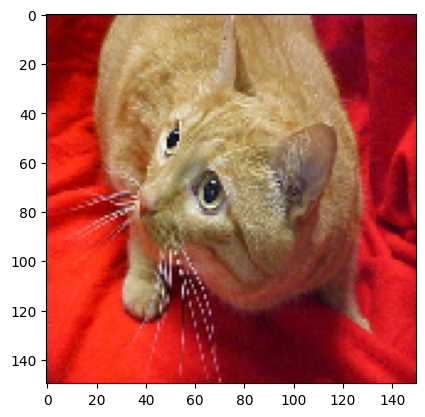

In [22]:
## Test the model by manually uploading images (single or multiple at a time)

import numpy as np
from ipywidgets import FileUpload
from tensorflow.keras.utils import load_img, img_to_array
import tempfile

# Create a file uploader widget
uploader = FileUpload(multiple=True)
display(uploader)

def on_upload_complete(change):
    for uploaded_file in uploader.value:
        with tempfile.NamedTemporaryFile(delete=False) as temp_file:
            temp_file.write(uploaded_file['content'])  # Write the file data using 'content'
            temp_file.flush()  # Ensure data is written to the file
            filename = temp_file.name  # Now filename contains the full path

            # Process the image
            img = load_img(filename, target_size=(150, 150))
            plt.imshow(img)
            x = img_to_array(img)
            x /= 255
            x = np.expand_dims(x, axis=0)
            images = np.vstack([x])

            classes = model.predict(images, batch_size=10)
            if classes[0] > 0.5:
                print("This is a dog")
            else:
                print("This is a cat")

uploader.observe(on_upload_complete, names='value')